[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shhommychon/mnist_generative_practice/blob/master/Diffusion.ipynb)

# MNIST Diffusion model 학습

## 환경설정

- PyTorch 버젼 다운그레이드 코드로 인해 세션이 자동으로 한번 꺼질 예정입니다. 다시 실행하면 됩니다.

In [1]:
# 현 CUDA 버젼 확인
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
# 파이썬 버젼 고정
import torch

# 현 PyTorch 버젼 확인
if torch.__version__.split('+')[0] != "1.11.0":
    print(f"Current PyTorch version is {torch.__version__}, downgrading to 1.11.0")

    # PyTorch 제거
    !pip uninstall torch torchvision -y

    # PyTorch 1.11.0 설치
    !pip install torch==1.11.0 torchvision==0.12.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

    # 런타임 강제 재시작
    import os
    os.kill(os.getpid(), 9)
else:
    print("PyTorch version is already 1.11.0")

PyTorch version is already 1.11.0


In [3]:
!git clone https://github.com/shhommychon/mnist_generative_practice.git

import sys
sys.path = ["./mnist_generative_practice"] + sys.path

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 12), reused 30 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.60 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
!apt install megatools

# mnist_feature_extractor.dth
!megadl 'https://mega.nz/file/DgUQyDyB#7Gyq_9kzCz8FcGZV659VD1Cq1_36wimGVOG2Eram3P8'

# mnist_classifier.dth
!megadl 'https://mega.nz/file/H49S3bTI#qsonzlkV3JMniTbyzV77BB9VLhwmh1OJLTgxuD4PEMM'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 2s (130 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_feature_extractor.dth
Downloaded mnist_classifier.dth


## 실습 코드

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

### MNIST 데이터셋 다운로드 및 불러오기

- 다운로드 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#downloading-datasets)
- 불러오기 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#splitting-datasets)

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


### 모델 및 손실함수/옵티마이저 등 설정

In [7]:
# Diffusion model 학습 보조용 사전학습 MNIST 분류기
from models.classifier import MNISTClassifier

c_model = MNISTClassifier()
c_model.feature_extractor.load_state_dict(torch.load("mnist_feature_extractor.dth"))
c_model.classifier.load_state_dict(torch.load("mnist_classifier.dth"))

if (torch.cuda.is_available()): c_model.cuda()

# freeze
for param in c_model.parameters(): param.requires_grad = False

c_model

MNISTClassifier(
  (feature_extractor): ConvFeatExtractor(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear): Linear(in_features=3136, out_features=128, bias=True)
    (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
  )
  (classifier): ClassifierHead(
    (dropout): SoftDropout(
      (dropouts): ModuleList(
        (0): Dropout(p=0.5, inplace=False)
        (1): Dropout(p=0.5, inplace=False)
        (2): Dropout(p=0.5, inplace=False)
        (3): Dropout(p=0.5, inplace=False)
        (4): Dropout(p=0.5, inplace=False)
      )
    )
    (relu): ReLU()
    (linear): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [8]:
from models.diffusion import MNISTDiffusion

model = MNISTDiffusion()

if (torch.cuda.is_available()): model.cuda()

model

MNISTDiffusion(
  (label_emb): Embedding(10, 32)
  (linear): Linear(in_features=816, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

In [9]:
pixelwise_loss = nn.L1Loss()
classification_loss = nn.CrossEntropyLoss()

lr=0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

decay_rate = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

max_epochs = 100
best_val_loss = 100
max_patience = 5

### 이미지 생성 코드

- 학습 중간 확인 용도

In [10]:
def generate_images(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        for _ in range(model.num_steps):
            noise = model(noise, class_label)
        recon_image = noise.clone()

    return recon_image

### 모델 학습 코드


Epoch: 1/100,
	Train Loss: 1.39808421
		classification loss: 1.30057187
		pixelwise loss: 1.36556991
	Val Loss: 1.29335500
		classification loss: 0.02239720
		pixelwise loss: 1.29279507


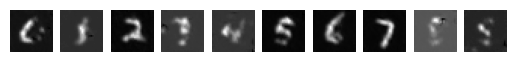

	Saving the model state dictionary for Epoch: 1 with Validation loss: 1.29335500

Epoch: 2/100,
	Train Loss: 0.92827873
		classification loss: 0.53239421
		pixelwise loss: 0.91496888
	Val Loss: 1.15609432
		classification loss: 0.41276265
		pixelwise loss: 1.14577526


<Figure size 640x480 with 0 Axes>

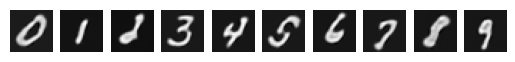

	Saving the model state dictionary for Epoch: 2 with Validation loss: 1.15609432

Epoch: 3/100,
	Train Loss: 0.82955985
		classification loss: 0.58253990
		pixelwise loss: 0.81499635
	Val Loss: 1.17633220
		classification loss: 0.74304217
		pixelwise loss: 1.15775614


<Figure size 640x480 with 0 Axes>

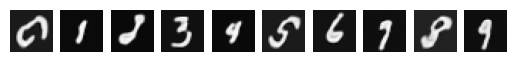

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 4/100,
	Train Loss: 0.81516953
		classification loss: 0.58745648
		pixelwise loss: 0.80048311
	Val Loss: 1.16424983
		classification loss: 0.56122189
		pixelwise loss: 1.15021929


<Figure size 640x480 with 0 Axes>

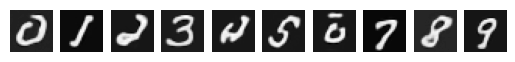

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 5/100,
	Train Loss: 0.80881412
		classification loss: 0.59113481
		pixelwise loss: 0.79403575
	Val Loss: 1.16409157
		classification loss: 0.55470707
		pixelwise loss: 1.15022389


<Figure size 640x480 with 0 Axes>

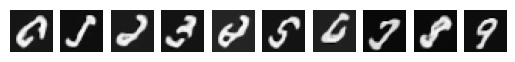

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 6/100,
	Train Loss: 0.80378912
		classification loss: 0.58768244
		pixelwise loss: 0.78909706
	Val Loss: 1.13667371
		classification loss: 0.45723454
		pixelwise loss: 1.12524285


<Figure size 640x480 with 0 Axes>

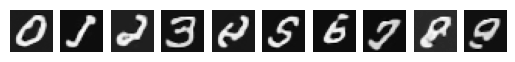

	Saving the model state dictionary for Epoch: 6 with Validation loss: 1.13667371

Epoch: 7/100,
	Train Loss: 0.80363220
		classification loss: 0.57453689
		pixelwise loss: 0.78926878
	Val Loss: 1.15557227
		classification loss: 0.44767567
		pixelwise loss: 1.14438038


<Figure size 640x480 with 0 Axes>

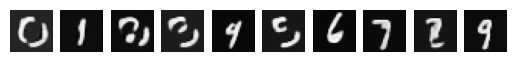

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 8/100,
	Train Loss: 0.79436148
		classification loss: 0.56016835
		pixelwise loss: 0.78035727
	Val Loss: 1.11712120
		classification loss: 0.35696146
		pixelwise loss: 1.10819716


<Figure size 640x480 with 0 Axes>

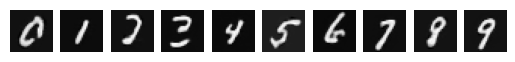

	Saving the model state dictionary for Epoch: 8 with Validation loss: 1.11712120

Epoch: 9/100,
	Train Loss: 0.78998915
		classification loss: 0.54369005
		pixelwise loss: 0.77639690
	Val Loss: 1.12347119
		classification loss: 0.31130283
		pixelwise loss: 1.11568862


<Figure size 640x480 with 0 Axes>

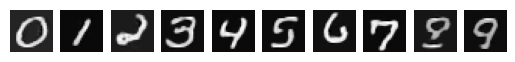

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 10/100,
	Train Loss: 0.78362085
		classification loss: 0.53284878
		pixelwise loss: 0.77029963
	Val Loss: 1.12016473
		classification loss: 0.48674860
		pixelwise loss: 1.10799602


<Figure size 640x480 with 0 Axes>

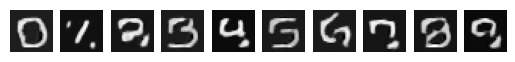

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 11/100,
	Train Loss: 0.77940041
		classification loss: 0.52859227
		pixelwise loss: 0.76618560
	Val Loss: 1.13077719
		classification loss: 0.74906696
		pixelwise loss: 1.11205052


<Figure size 640x480 with 0 Axes>

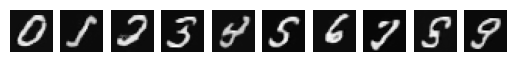

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 12/100,
	Train Loss: 0.77600873
		classification loss: 0.51758668
		pixelwise loss: 0.76306906
	Val Loss: 1.11673849
		classification loss: 0.54111642
		pixelwise loss: 1.10321058


<Figure size 640x480 with 0 Axes>

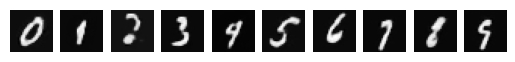

	Saving the model state dictionary for Epoch: 12 with Validation loss: 1.11673849

Epoch: 13/100,
	Train Loss: 0.77555810
		classification loss: 0.51399090
		pixelwise loss: 0.76270833
	Val Loss: 1.11171615
		classification loss: 0.43331432
		pixelwise loss: 1.10088329


<Figure size 640x480 with 0 Axes>

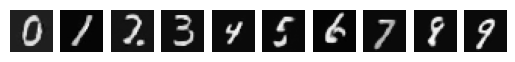

	Saving the model state dictionary for Epoch: 13 with Validation loss: 1.11171615

Epoch: 14/100,
	Train Loss: 0.77266418
		classification loss: 0.51310699
		pixelwise loss: 0.75983651
	Val Loss: 1.10407176
		classification loss: 0.38061797
		pixelwise loss: 1.09455631


<Figure size 640x480 with 0 Axes>

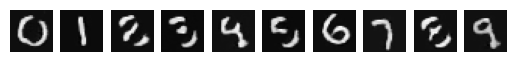

	Saving the model state dictionary for Epoch: 14 with Validation loss: 1.10407176

Epoch: 15/100,
	Train Loss: 0.77190650
		classification loss: 0.50615688
		pixelwise loss: 0.75925258
	Val Loss: 1.10607279
		classification loss: 0.38266036
		pixelwise loss: 1.09650628


<Figure size 640x480 with 0 Axes>

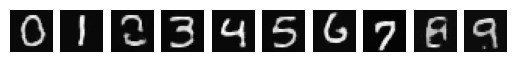

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 16/100,
	Train Loss: 0.77163360
		classification loss: 0.50386406
		pixelwise loss: 0.75903699
	Val Loss: 1.11619726
		classification loss: 0.31308013
		pixelwise loss: 1.10837026


<Figure size 640x480 with 0 Axes>

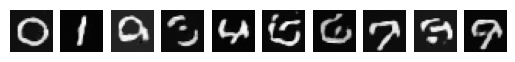

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 17/100,
	Train Loss: 0.76801136
		classification loss: 0.49862006
		pixelwise loss: 0.75554585
	Val Loss: 1.09815160
		classification loss: 0.39804197
		pixelwise loss: 1.08820054


<Figure size 640x480 with 0 Axes>

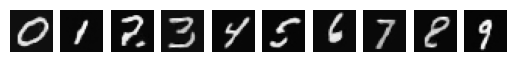

	Saving the model state dictionary for Epoch: 17 with Validation loss: 1.09815160

Epoch: 18/100,
	Train Loss: 0.76679989
		classification loss: 0.49451937
		pixelwise loss: 0.75443691
	Val Loss: 1.09933881
		classification loss: 0.30568658
		pixelwise loss: 1.09169664


<Figure size 640x480 with 0 Axes>

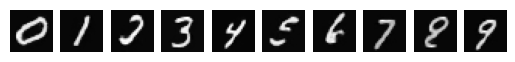

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 19/100,
	Train Loss: 0.76486067
		classification loss: 0.49260219
		pixelwise loss: 0.75254561
	Val Loss: 1.10943428
		classification loss: 0.36597270
		pixelwise loss: 1.10028496


<Figure size 640x480 with 0 Axes>

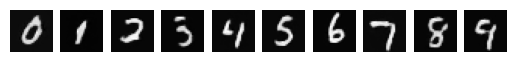

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 20/100,
	Train Loss: 0.76297043
		classification loss: 0.48910265
		pixelwise loss: 0.75074287
	Val Loss: 1.08950857
		classification loss: 0.24981742
		pixelwise loss: 1.08326314


<Figure size 640x480 with 0 Axes>

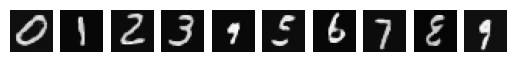

	Saving the model state dictionary for Epoch: 20 with Validation loss: 1.08950857

Epoch: 21/100,
	Train Loss: 0.76053380
		classification loss: 0.48174913
		pixelwise loss: 0.74849007
	Val Loss: 1.09197798
		classification loss: 0.29500140
		pixelwise loss: 1.08460294


<Figure size 640x480 with 0 Axes>

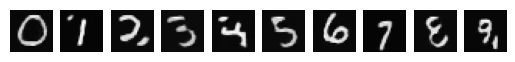

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 22/100,
	Train Loss: 0.75984097
		classification loss: 0.47711577
		pixelwise loss: 0.74791308
	Val Loss: 1.08611832
		classification loss: 0.20088617
		pixelwise loss: 1.08109617


<Figure size 640x480 with 0 Axes>

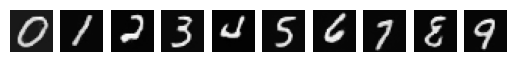

	Saving the model state dictionary for Epoch: 22 with Validation loss: 1.08611832

Epoch: 23/100,
	Train Loss: 0.75853995
		classification loss: 0.48008222
		pixelwise loss: 0.74653789
	Val Loss: 1.08713272
		classification loss: 0.33812250
		pixelwise loss: 1.07867966


<Figure size 640x480 with 0 Axes>

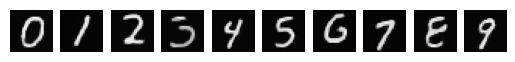

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 24/100,
	Train Loss: 0.75848737
		classification loss: 0.47414534
		pixelwise loss: 0.74663373
	Val Loss: 1.10636017
		classification loss: 0.34545602
		pixelwise loss: 1.09772377


<Figure size 640x480 with 0 Axes>

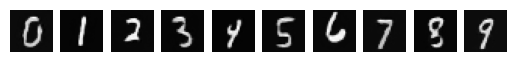

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 25/100,
	Train Loss: 0.75798251
		classification loss: 0.47410362
		pixelwise loss: 0.74612992
	Val Loss: 1.08791217
		classification loss: 0.30560367
		pixelwise loss: 1.08027208


<Figure size 640x480 with 0 Axes>

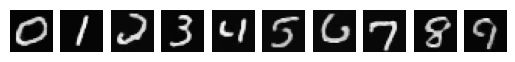

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 26/100,
	Train Loss: 0.75489327
		classification loss: 0.47139786
		pixelwise loss: 0.74310832
	Val Loss: 1.09709670
		classification loss: 0.27321190
		pixelwise loss: 1.09026640


<Figure size 640x480 with 0 Axes>

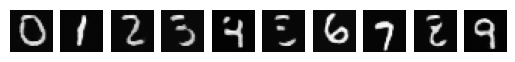

	Loss not decreased. Will wait for 1 more epochs...

Epoch: 27/100,
	Train Loss: 0.75412686
		classification loss: 0.46787442
		pixelwise loss: 0.74243000
	Val Loss: 1.08704869
		classification loss: 0.22408570
		pixelwise loss: 1.08144654


<Figure size 640x480 with 0 Axes>

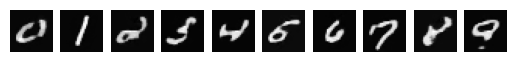

	Loss not decreased. Will wait for 0 more epochs...


<Figure size 640x480 with 0 Axes>

In [11]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"
patience = max_patience
for epoch in range(max_epochs):
    total_train_loss = {
        "loss_class": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }
    total_val_loss = {
        "loss_class": 0,
        "loss_pixel": 0,
        "loss_total": 0,
    }

    model.train()

    # training
    for iter, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)

        # Forward diffusion process
        noisy_images = [image.clone()]
        noisy_image = image.clone()
        for _ in range(model.num_steps):
            noisy_image = model(noisy_image, backward=False)
            noisy_images.append(noisy_image.clone())

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward diffusion process
        recon_image = noisy_images.pop()
        train_pixel_loss = torch.tensor(0.).to(device)
        train_class_loss = torch.tensor(0.).to(device)
        for _ in range(model.num_steps):
            recon_image = model(recon_image, label)
            train_pixel_loss += pixelwise_loss(recon_image, image) # noisy_images[-1])
            class_pred = c_model(recon_image)
            train_class_loss += classification_loss(class_pred, label)
            recon_image = noisy_images.pop()

        # loss computation and backpropagation
        this_train_loss = train_pixel_loss + 0.025 * train_class_loss
        this_train_loss.backward()

        # Update diffusion model parameters
        optimizer.step()

        total_train_loss["loss_class"] += train_class_loss.item()
        total_train_loss["loss_pixel"] += train_pixel_loss.item()
        total_train_loss["loss_total"] += this_train_loss.item()

    # Step the learning rate schedulers
    scheduler.step()

    total_train_loss = { k: train_loss / (iter + 1) for k, train_loss
                                                in total_train_loss.items() }

    # validation
    model.eval()

    for iter, (image, label) in enumerate(val_dataloader):
        image = image.to(device)
        label = label.to(device)

        # Forward diffusion process
        noisy_images = [image.clone()]
        noisy_image = image.clone()
        for _ in range(model.num_steps):
            noisy_image = model(noisy_image, backward=False)
            noisy_images.append(noisy_image.clone())

        # Backward diffusion process
        recon_image = noisy_images.pop()
        val_pixel_loss = torch.tensor(0.).to(device)
        val_class_loss = torch.tensor(0.).to(device)
        for _ in range(model.num_steps):
            recon_image = model(recon_image, label)
            val_pixel_loss += pixelwise_loss(recon_image, image) # noisy_images[-1])
            class_pred = c_model(recon_image)
            val_class_loss += classification_loss(class_pred, label)
            _ = noisy_images.pop()

        total_val_loss["loss_class"] += val_class_loss.item()
        total_val_loss["loss_pixel"] += val_pixel_loss.item()
        total_val_loss["loss_total"] += (val_pixel_loss + 0.025 * val_class_loss).item()

    total_val_loss = { k: val_loss / (iter + 1) for k, val_loss
                                                in total_val_loss.items() }

    print(f"\nEpoch: {epoch+1}/{max_epochs},"
          f"\n\tTrain Loss: {total_train_loss['loss_total']:.8f}"
          f"\n\t\tclassification loss: {total_train_loss['loss_class']:.8f}"
          f"\n\t\tpixelwise loss: {total_train_loss['loss_pixel']:.8f}"
          f"\n\tVal Loss: {total_val_loss['loss_total']:.8f}"
          f"\n\t\tclassification loss: {total_val_loss['loss_class']:.8f}"
          f"\n\t\tpixelwise loss: {total_val_loss['loss_pixel']:.8f}")

    noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
    class_label = torch.tensor([ n for n in range(10) ]).to(device)
    result = generate_images(model, noise, class_label).cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=10)
    for i, image in enumerate(result):
        plt.subplot(1, 10, i+1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
    plt.clf()

    if total_val_loss["loss_total"] < best_val_loss:
        best_val_loss = total_val_loss["loss_total"]
        print(f"\tSaving the model state dictionary for Epoch: {epoch+1} with Validation loss: {best_val_loss:.8f}")
        torch.save(model.state_dict(), "mnist_diffusion.dth")
        patience = max_patience
    else:
        patience -= 1
        print(f"\tLoss not decreased. Will wait for {patience} more epochs...")

    if patience <= 0: break


### 사전학습 모델 불러오기

- 위 모델 학습 코드를 실행하기 귀찮을 경우에만 이 셀을 실행

In [12]:
!apt install megatools

# mnist_diffusion.dth
!megadl 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

ERROR: Download failed for 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4': Can't rename donwloaded temporary file /content/.megatmp.Sg90lRhQ to /content/mnist_diffusion.dth (downloaded data are good!): Error moving file /content/.megatmp.Sg90lRhQ: File exists


### 학습 모델 테스트

#### 일반 이미지 생성

In [13]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth"))

if (torch.cuda.is_available()): model.cuda()

model.eval()

MNISTDiffusion(
  (label_emb): Embedding(10, 32)
  (linear): Linear(in_features=816, out_features=784, bias=True)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

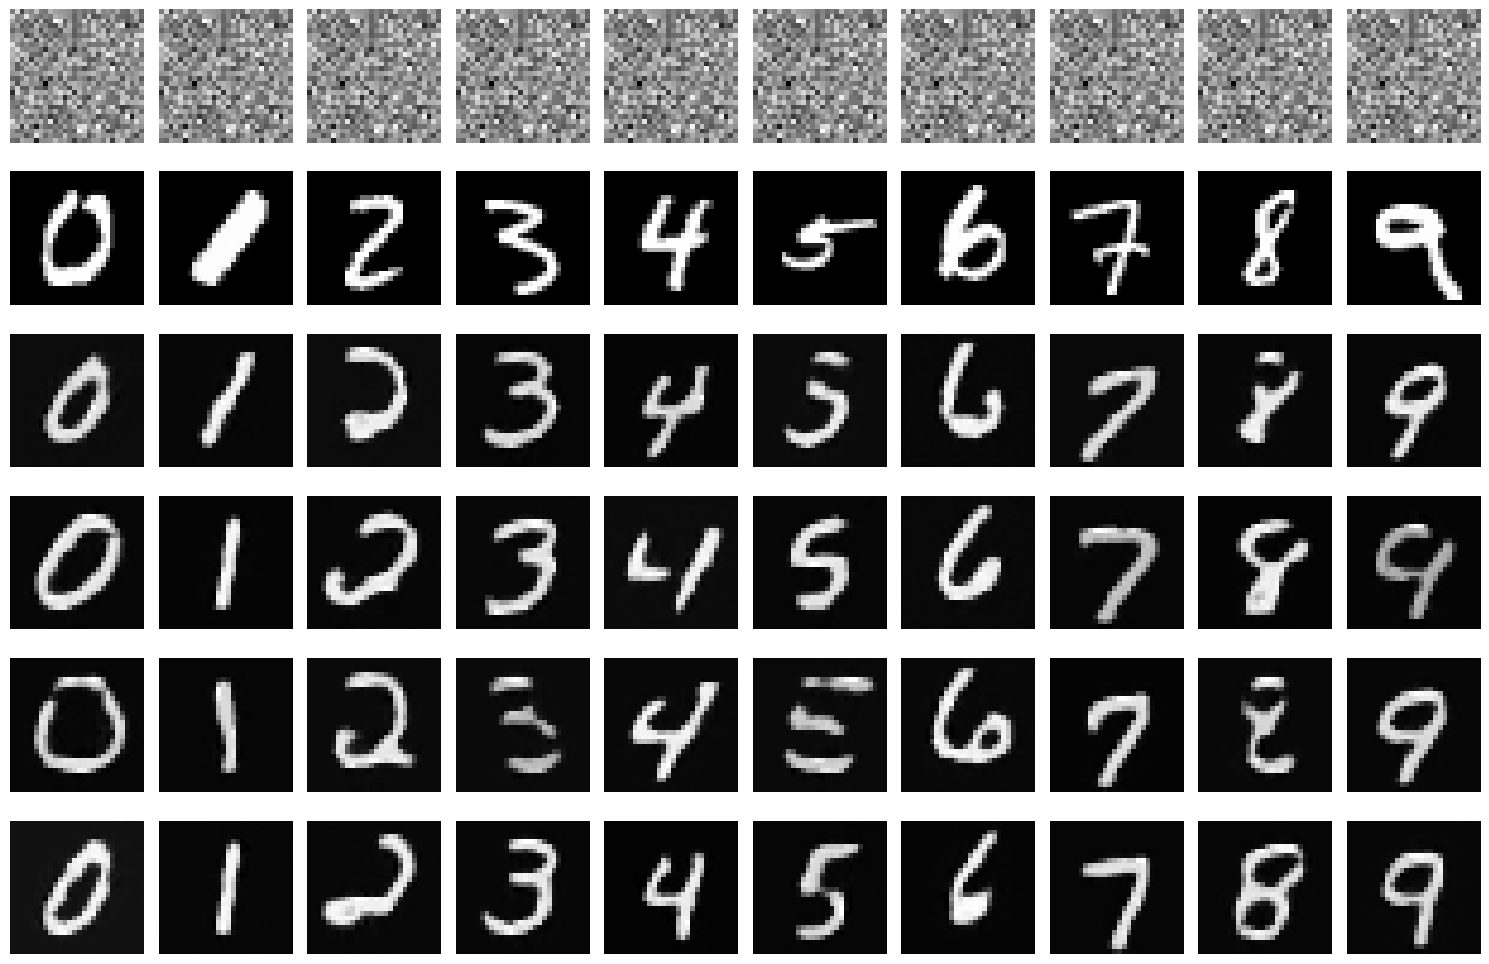

In [25]:
# MNIST 데이터셋 실제 샘플들 및 생성 결과들 저장

original = [None for _ in range(10)]

# 실제 샘플 저장
stop = False
for iter, (image_batch, label_batch) in enumerate(test_dataloader):
    for image, label in zip(image_batch, label_batch):
        label = label.item()

        if original[label] is None:
            original[label] = image.data

        if None not in original:
            stop = True
            break
    if stop:
        break

# 동일 노이즈 사용하여 이미지 생성
noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([n for n in range(10)]).to(device)
result1 = generate_images(model, noise, class_label).cpu().detach().numpy()

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([n for n in range(10)]).to(device)
result2 = generate_images(model, noise, class_label).cpu().detach().numpy()

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([n for n in range(10)]).to(device)
result3 = generate_images(model, noise, class_label).cpu().detach().numpy()

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([n for n in range(10)]).to(device)
result4 = generate_images(model, noise, class_label).cpu().detach().numpy()

# 시각화 부분 수정
import matplotlib.pyplot as plt

image_dim = 28
fig, axes = plt.subplots(nrows=6, ncols=10, figsize=(15, 10))

# 노이즈 시각화 (첫 번째 행)
noise_image = noise[0].cpu().detach().numpy().reshape(image_dim, image_dim)
for i in range(10):
    axes[0, i].imshow(noise_image, cmap="gray")
    axes[0, i].axis("off")

# 실제 MNIST 샘플 시각화 (두 번째 행)
for i, image in enumerate(original):
    axes[1, i].imshow(image.cpu().numpy().reshape(image_dim, image_dim), cmap="gray")
    axes[1, i].axis("off")

# 결과 1 시각화 (세 번째 행)
for i, image in enumerate(result1):
    axes[2, i].imshow(image.reshape(image_dim, image_dim), cmap="gray")
    axes[2, i].axis("off")

# 결과 2 시각화 (네 번째 행)
for i, image in enumerate(result2):
    axes[3, i].imshow(image.reshape(image_dim, image_dim), cmap="gray")
    axes[3, i].axis("off")

# 결과 3 시각화 (다섯 번째 행)
for i, image in enumerate(result3):
    axes[4, i].imshow(image.reshape(image_dim, image_dim), cmap="gray")
    axes[4, i].axis("off")

# 결과 4 시각화 (여섯 번째 행)
for i, image in enumerate(result4):
    axes[5, i].imshow(image.reshape(image_dim, image_dim), cmap="gray")
    axes[5, i].axis("off")

plt.tight_layout()
plt.show()


#### 이미지 생성 단계별 확인

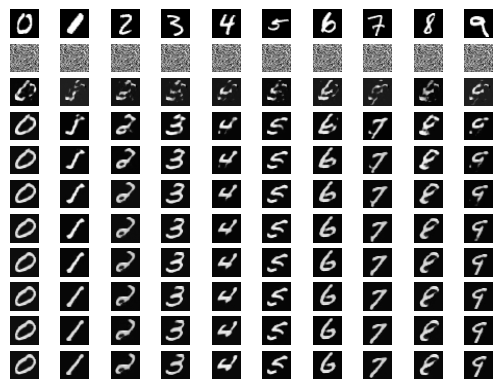

In [30]:
def generate_images2(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        recon_images = list()
        for _ in range(model.num_steps):
            recon_images.append(noise.view(class_label.size(0), 1, 28, 28).cpu().detach().numpy())
            noise = model(noise, class_label)


    return recon_images

noise = torch.randn(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([ n for n in range(10) ]).to(device)
results = np.array(generate_images2(model, noise, class_label))


# MNIST 데이터셋 실제 샘플들, Diffusion step별 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=11, ncols=10)

for i, image in enumerate(original):
    plt.subplot(11, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for j, result in enumerate(results):
    for i, image in enumerate(result):
        plt.subplot(11, 10, (j+2)*10-(9-i))
        plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
        plt.axis("off")

plt.show()

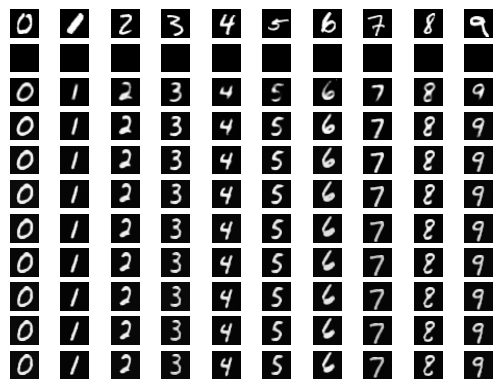

In [31]:
def generate_images2(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        recon_images = list()
        for _ in range(model.num_steps):
            recon_images.append(noise.view(class_label.size(0), 1, 28, 28).cpu().detach().numpy())
            noise = model(noise, class_label)


    return recon_images

noise = torch.zeros(1, 1, 28, 28).repeat(10, 1, 1, 1).to(device)
class_label = torch.tensor([ n for n in range(10) ]).to(device)
results = np.array(generate_images2(model, noise, class_label))


# MNIST 데이터셋 실제 샘플들, Diffusion step별 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=11, ncols=10)

for i, image in enumerate(original):
    plt.subplot(11, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for j, result in enumerate(results):
    for i, image in enumerate(result):
        plt.subplot(11, 10, (j+2)*10-(9-i))
        plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
        plt.axis("off")

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


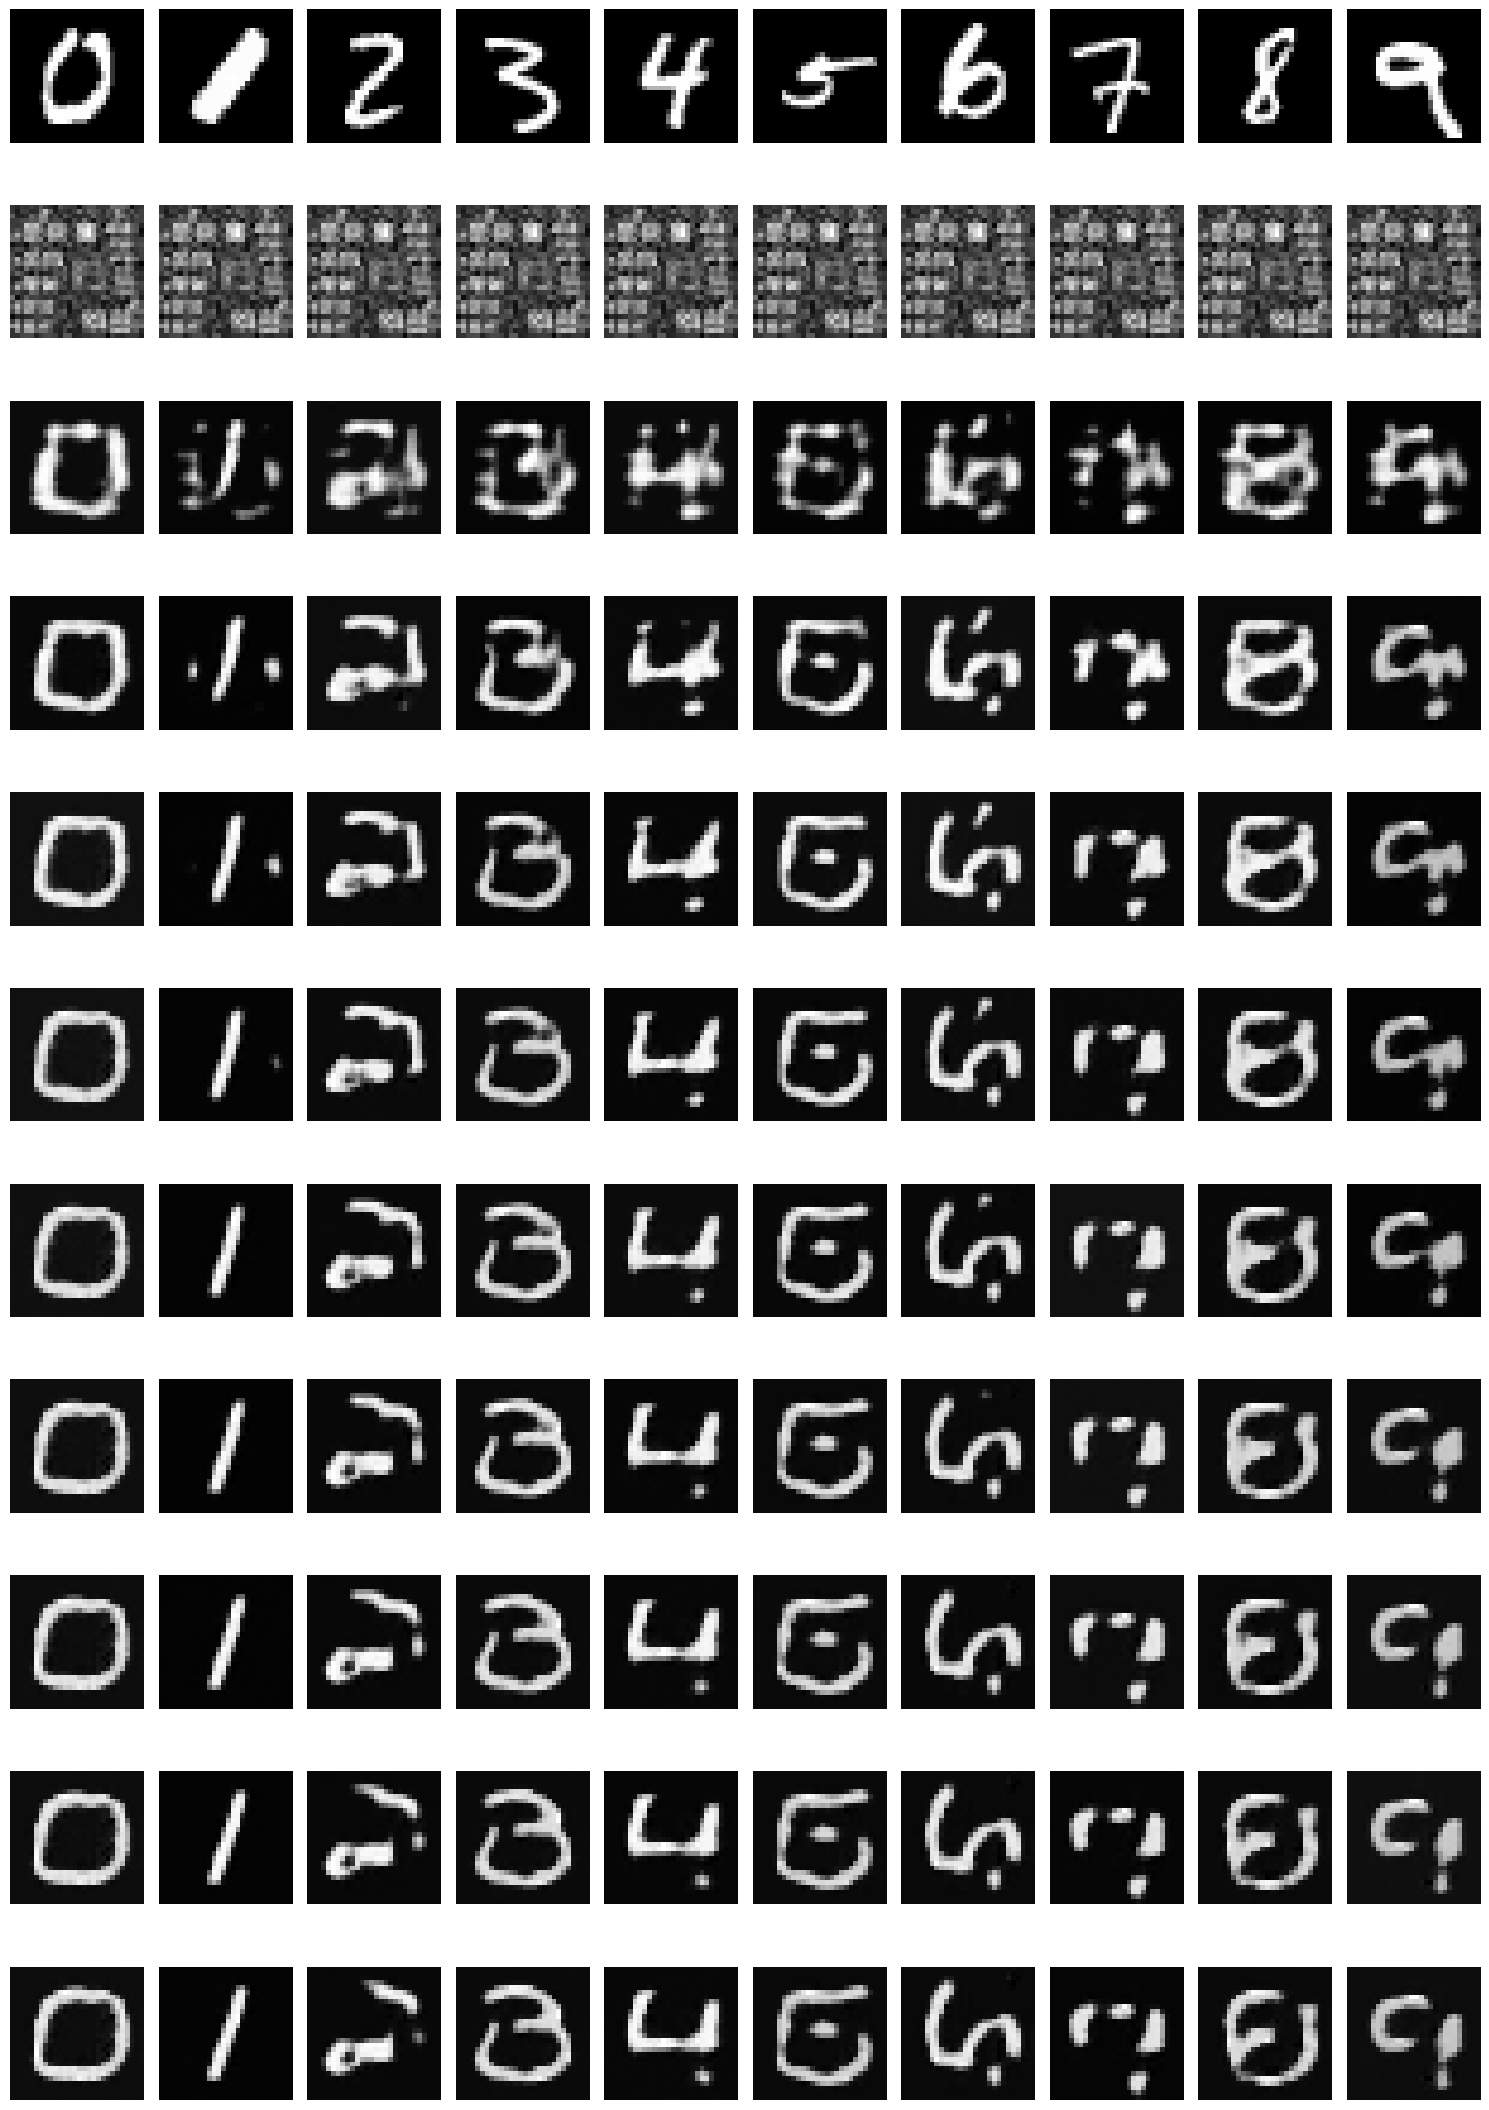

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# 필요한 경우 Google Drive 마운트 및 경로 설정
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/"
os.chdir(data_path)

# 모델이 사용 중인 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델의 num_steps 확인 (예: 10으로 가정)
model.num_steps = 10  # 모델에 따라 적절히 설정하세요

# MNIST 데이터셋 실제 샘플들 로드 (기존 코드 유지)
original = [None for _ in range(10)]

# 실제 샘플 저장 (기존 코드 유지)
stop = False
for iter, (image_batch, label_batch) in enumerate(test_dataloader):
    for image, label in zip(image_batch, label_batch):
        label = label.item()
        if original[label] is None:
            original[label] = image.data
        if None not in original:
            stop = True
            break
    if stop:
        break

# 1. 이미지 로드 및 전처리
image = Image.open('USAF1000.png').convert('L')  # 흑백 이미지로 변환
image = image.resize((28, 28))  # 크기 조정
image = np.array(image) / 255.0  # [0, 1]로 정규화
image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 28, 28]

# 2. 노이즈 추가 함수 정의 및 타임스텝 설정
T = 300  # 전체 타임스텝 수 (모델 학습 시 사용된 값과 동일하게 설정)
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

def add_noise(x0, t):
    noise = torch.randn_like(x0).to(device)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
    xt = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
    return xt

t_start = 20  # 노이즈를 추가할 타임스텝
noisy_image = add_noise(image, t_start)

# 3. 노이즈 이미지로부터 생성 과정 실행
def generate_images2(model, noise, class_label):
    model.eval()
    with torch.no_grad():
        recon_images = list()
        for _ in range(model.num_steps):
            recon_images.append(noise.view(-1, 1, 28, 28).cpu().detach().numpy())
            noise = model(noise, class_label)
    return recon_images

# 클래스 레이블 설정 (필요에 따라 조정)
class_label = torch.tensor([n for n in range(10)]).to(device)  # 여기서는 10개의 레이블 사용

# 노이즈 이미지를 10개로 복제하여 배치 생성
noisy_images = noisy_image.repeat(10, 1, 1, 1)

# 4. 생성 과정 실행
results = np.array(generate_images2(model, noisy_images, class_label))

# 5. 시각화
image_dim = 28
num_steps = results.shape[0]
fig, axes = plt.subplots(nrows=num_steps + 1, ncols=10, figsize=(15, (num_steps + 1) * 2))

# 첫 번째 행: 실제 MNIST 샘플 시각화
for i, image in enumerate(original):
    axes[0, i].imshow(image.cpu().numpy().reshape(image_dim, image_dim), cmap="gray")
    axes[0, i].axis("off")

# 그 이후 행: 생성된 이미지 시각화
for j in range(num_steps):
    for i in range(10):
        axes[j + 1, i].imshow(results[j, i, 0], cmap="gray")
        axes[j + 1, i].axis("off")

plt.tight_layout()
plt.show()
